# UK Politics: From Words to Votes

This dataset contains 3 files: one with speeches extracted from britishpolicalspeech.org (12k rows), one with speeches from ukpol.co.uk (350 rows) and one with the UK members of parliament since 1970, including party affiliation, obtained from Wikidata.

## Data exploratory

In [11]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from adjustText import adjust_text
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cbouton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cbouton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cbouton\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
df_speeches = pd.read_csv('./data/speeches_ukpol.csv')
df_speeches.drop(columns=df_speeches.columns[0], axis=1, inplace=True)
df_speeches.head()

,Speaker,Year,Description,Speech
0,Diane Abbott,NaN,Below is the text of the speech made by Diane ...,The fact that the House of Commons has spent t...
1,Diane Abbott,2018.0,Below is the text of the speech made by Diane ...,Thank you Chair. Thank you Conference. It’s gr...
2,Diane Abbott,2019.0,Below is the text of the speech made by Diane ...,I thank the Home Secretary for his account of ...
3,Diane Abbott,2020.0,Below is the text of the speech made by Diane ...,"We live in extraordinary times. Unfortunately,..."
4,Diane Abbott,2020.0,Below is the text of the speech made by Diane ...,Like my good friend the right hon. Member for ...


In [13]:
df_speakers = pd.read_csv('./data/MPs_1970_onwards.csv')
df_speakers.head()

,item,itemLabel,constituencyLabel,partyLabel,start,electionLabel,end,endcauseLabel,noteLabel
0,http://www.wikidata.org/entity/Q265935,Nick Brown,Newcastle upon Tyne East,independent politician,2022-09-07T00:00:00Z,2019 United Kingdom general election,NaN,NaN,NaN
1,http://www.wikidata.org/entity/Q580464,Penny Mordaunt,NaN,NaN,2022-09-06T00:00:00Z,NaN,NaN,NaN,NaN
2,http://www.wikidata.org/entity/Q303299,Tobias Ellwood,Bournemouth East,independent politician,2022-07-19T00:00:00Z,NaN,NaN,NaN,NaN
3,http://www.wikidata.org/entity/Q575266,Christopher Pincher,Tamworth,independent politician,2022-06-30T00:00:00Z,NaN,NaN,NaN,NaN
4,http://www.wikidata.org/entity/Q19883135,Patrick Grady,Glasgow North,independent politician,2022-06-26T00:00:00Z,NaN,NaN,NaN,NaN


In [14]:
def binarize_party(label: str) -> int|None:
    if label == 'Labour Party':
        return 0
    elif label == 'Conservative Party':
        return 1
    else:
        return None

In [15]:
df_speakers['party'] = df_speakers['partyLabel'].apply(binarize_party)

In [16]:
df_speakers = df_speakers[['itemLabel', 'party']].groupby('itemLabel').mean().reset_index()
df_speakers = df_speakers[df_speakers['party'].isin([0, 1, np.nan])]

In [17]:
df_speakers.rename(columns={'itemLabel': 'Speaker'}, inplace=True)

In [18]:
df_merged = pd.merge(df_speeches, df_speakers, on='Speaker')

In [19]:
indexes_to_drop = [275, 429, 1575, 1929, 1930, 1931, 3309, 3310, 3629, 3688, 4686, 4842, 4994, 5474, 5475, 5508, 5526, 5581, 5597, 5601, 5611, 6097, 6279, 6609, 7820, 8192, 8289]
df_merged = df_merged.drop(index=indexes_to_drop)

In [20]:
df_merged = df_merged.dropna(subset=['Speaker', 'Speech'])
df_merged = df_merged[(df_merged['Speaker'] != '') & (df_merged['Speech'] != '') & (df_merged['party'] != '')]
df_merged = df_merged[df_merged['Year'] >= 1970]

In [21]:
len(df_merged)

9919

In [22]:
df_merged.isna().sum()

Speaker           0
Year              0
Description      67
Speech            0
party          1018
dtype: int64

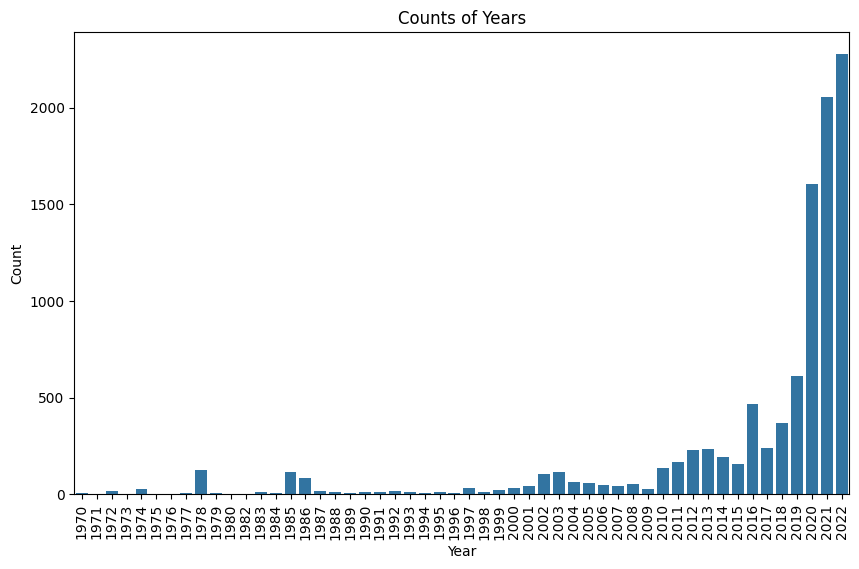

In [23]:
year_counts = df_merged['Year'].value_counts()
x_years = year_counts.index.astype(int)
x_years.sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=x_years, y=year_counts)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Counts of Years')
plt.xticks(rotation=90)
plt.show()

## Preprocessing NLP

### Extracting the speeches column

In [24]:
raw_speeches = df_merged['Speech'].values.tolist()

In [25]:
speeches = [element.lower() for element in raw_speeches]

### Splitting the words for each speech

In [26]:
def tokenize(speeches: list[str]) -> list[list[str]]:
    speeches_token = []
    for speech in tqdm(speeches):
        speeches_token.append(nltk.tokenize.word_tokenize(speech))
    return speeches_token

In [27]:
speeches = tokenize(speeches)

100%|██████████| 9919/9919 [01:09<00:00, 142.24it/s]


In [28]:
word_count = [len(speech) for speech in speeches]

In [29]:
min(word_count), np.median(word_count), max(word_count)

(2, 819.0, 13237)

Some speeches are suspiciously too short. We will have to remove them during the sets splitting.

### Removing stopwords

In [30]:
def remove_stopwords(speeches: list[list[str]]) -> list[list[str]]:
    stop_words = stopwords.words('english')
    speeches_filtered = []
    for speech in tqdm(speeches):
        tokens = []
        for w in speech:
            if w not in stop_words and len(w) > 2 and w.isalpha() and w != 'none':
                tokens.append(w)
        speeches_filtered.append(tokens)
    return speeches_filtered

In [31]:
speeches = remove_stopwords(speeches)

100%|██████████| 9919/9919 [00:23<00:00, 419.21it/s]


### Stemming

In [32]:
def stem(speeches: list[list[str]]) -> list[list[str]]:
    speeches_stem = []
    stemmer = nltk.SnowballStemmer('english')
    for speech in tqdm(speeches):
        tokens = []
        for w in speech:
            tokens.append(stemmer.stem(w))
        speeches_stem.append(tokens)
    return speeches_stem

In [33]:
speeches = stem(speeches)

100%|██████████| 9919/9919 [01:22<00:00, 120.37it/s]


### Sentiment analysis

In [34]:
sia = SentimentIntensityAnalyzer()

sentiments = [sia.polarity_scores(speech)['compound'] for speech in tqdm(raw_speeches)]

100%|██████████| 9919/9919 [02:54<00:00, 56.81it/s] 


## Data splitting

In [35]:
speeches = [' '.join(token) for token in speeches]

In [36]:
data = pd.DataFrame({'party': df_merged['party'], 'speech': speeches, 'word_count': word_count, 'sentiment': sentiments})
data.sample(10, random_state=99)

,party,speech,word_count,sentiment
8177,1.0,statutori instrument laid septemb titl motor v...,356,0.8647
3650,1.0,rapid test vital part roadmap help cautious li...,101,0.9643
233,0.0,virus gone away could easili get control witho...,92,0.6486
8301,1.0,thank much deputi speaker transpar make hous a...,4437,-0.9996
10018,1.0,welcom session delight david davi shailesh var...,1578,0.9991
7147,1.0,permiss would like make statement first want b...,775,0.9942
6526,0.0,busi across face black hole winter billion wip...,98,-0.6430
8437,1.0,alway prepar justifi vote parliament account c...,176,0.7579
1225,1.0,prime minist thank well thank welcom great sie...,7839,1.0000
2393,NaN,echo comment hon friend member swansea east ca...,582,-0.9063


In [37]:
len(data)

9919

In [38]:
data.drop(data[data['word_count'] <= 10].index, inplace=True)
len(data)

9898

In [39]:
data[data['party'] == 0]['sentiment'].describe(), data[data['party'] == 1]['sentiment'].describe()

(count    2780.000000
 mean        0.328962
 std         0.831461
 min        -0.999900
 25%        -0.723850
 50%         0.916900
 75%         0.998200
 max         1.000000
 Name: sentiment, dtype: float64,
 count    6101.000000
 mean        0.762043
 std         0.568911
 min        -0.999900
 25%         0.940300
 50%         0.995900
 75%         0.999600
 max         1.000000
 Name: sentiment, dtype: float64)

In [40]:
test = data[data['party'].isna()]
test.head()

,party,speech,word_count,sentiment
71,NaN,introduct thank point first cabinet minist hig...,2429,0.9997
73,NaN,subject open misunderstand misrepresent public...,4398,0.9999
74,NaN,introduct delight launch credit union stornowa...,1133,0.9996
76,NaN,wish updat hous progress reform public servic ...,1839,0.9997
79,NaN,good morn give great pleasur open breakfast me...,895,0.9994


In [41]:
len(test)

1017

In [42]:
data = data[data['party'].notna()]

In [43]:
len(data)

8881

In [44]:
train, val = train_test_split(data, test_size=0.2, shuffle=True, random_state=50, stratify=data['party'])

In [45]:
y_train = train['party']
X_train = train['speech']

y_val = val['party']
X_val = val['speech']

## Vectorization

In [46]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
len(X_train)

7104

In [47]:
X_val = vectorizer.transform(X_val)
X_val = pd.DataFrame(X_val.toarray(), columns=vectorizer.get_feature_names_out())
len(X_val)

1777

In [48]:
X_test = vectorizer.transform(test['speech'])
X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
len(X_test)

1017

In [49]:
X_train['sentiment'] = train['sentiment'].values

X_val['sentiment'] = val['sentiment'].values

X_test['sentiment'] = test['sentiment'].values

## Building the model

In [50]:
model = XGBRegressor(n_jobs=-1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
root_mean_squared_error(y_train, y_pred_train), root_mean_squared_error(y_val, y_pred_val)

(0.15223474831996373, 0.34112330395863066)

In [52]:
feature_importances_df = pd.DataFrame({'Feature': model.feature_names_in_, 'Importance': model.feature_importances_})
(feature_importances_df['Importance'] == 0).sum()/len(feature_importances_df)

0.9648667250656989

96% of features have no importance to our model. Let's get rid of them and try to fit our model.

In [53]:
useless_features = feature_importances_df[feature_importances_df['Importance'] == 0]['Feature']

X_train.drop(columns=useless_features, inplace=True)
X_val.drop(columns=useless_features, inplace=True)
X_test.drop(columns=useless_features, inplace=True)

In [54]:
model = XGBRegressor(n_jobs=-1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
y_pred_train = model.predict(X_train)
root_mean_squared_error(y_train, y_pred_train)

0.15223474831996373

In [56]:
y_pred_val = model.predict(X_val)
root_mean_squared_error(y_val, y_pred_val)

0.34112330395863066

In [57]:
y_pred_test = model.predict(X_test)

In [58]:
feature_importances_df = pd.DataFrame({'Feature': model.feature_names_in_, 'Importance': model.feature_importances_})
feature_importances_df.sort_values('Importance', ascending=False, inplace=True, ignore_index=True)
feature_importances_df.reset_index(inplace=True)

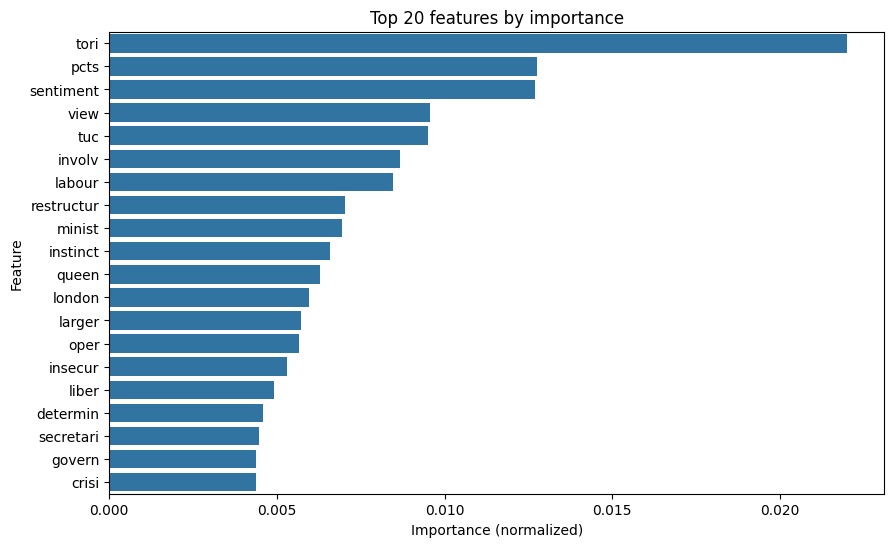

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20), orient='h')
plt.xlabel('Importance (normalized)')
plt.ylabel('Feature')
plt.title('Top 20 features by importance')
plt.show()

## Results analysis and plotting

In [60]:
def pred_to_df(preds: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    df['pred'] = preds
    return df

In [61]:
train = pred_to_df(y_pred_train, train)
train.head()

,party,speech,word_count,sentiment,pred
4605,1.0,incred impress posit respons receiv council fa...,103,0.9822,0.839909
2707,1.0,begin thank key worker north somerset keep ess...,669,-0.9362,0.778342
3864,0.0,govern consist let women frontlin forc minist ...,96,0.5860,0.255000
7897,0.0,week chanc govern back british busi help publi...,153,0.5859,-0.024378
10017,1.0,parti confer politician set stall seasid two w...,2753,0.9849,1.000239


In [62]:
val = pred_to_df(y_pred_val, val)
val.head()

,party,speech,word_count,sentiment,pred
9113,0.0,tori talk broken immigr system power decad pol...,81,0.8201,0.271117
7377,1.0,sad week thought lot teacher dedic countri giv...,527,0.9990,1.077550
2856,1.0,pleasur work associ school colleg leader ascl ...,2434,0.9998,1.005637
5932,1.0,great back amongst mani friend chairman met th...,2307,0.9999,0.991282
7898,0.0,encourag see first move toward global pact tax...,103,0.5574,0.156081


In [63]:
test = pred_to_df(y_pred_test, test)
test.head()

,party,speech,word_count,sentiment,pred
71,NaN,introduct thank point first cabinet minist hig...,2429,0.9997,0.843407
73,NaN,subject open misunderstand misrepresent public...,4398,0.9999,0.840818
74,NaN,introduct delight launch credit union stornowa...,1133,0.9996,0.998697
76,NaN,wish updat hous progress reform public servic ...,1839,0.9997,0.498910
79,NaN,good morn give great pleasur open breakfast me...,895,0.9994,0.854716


In [64]:
output = pd.concat([train, val, test], axis=0)
output.head()

,party,speech,word_count,sentiment,pred
4605,1.0,incred impress posit respons receiv council fa...,103,0.9822,0.839909
2707,1.0,begin thank key worker north somerset keep ess...,669,-0.9362,0.778342
3864,0.0,govern consist let women frontlin forc minist ...,96,0.5860,0.255000
7897,0.0,week chanc govern back british busi help publi...,153,0.5859,-0.024378
10017,1.0,parti confer politician set stall seasid two w...,2753,0.9849,1.000239


In [65]:
output = pd.merge(output, df_merged['Speaker'], left_index=True, right_index=True)
output

,party,speech,word_count,sentiment,pred,Speaker
4605,1.0,incred impress posit respons receiv council fa...,103,0.9822,0.839909,Robert Jenrick
2707,1.0,begin thank key worker north somerset keep ess...,669,-0.9362,0.778342,Liam Fox
3864,0.0,govern consist let women frontlin forc minist ...,96,0.5860,0.255000,John Healey
7897,0.0,week chanc govern back british busi help publi...,153,0.5859,-0.024378,Rachel Reeves
10017,1.0,parti confer politician set stall seasid two w...,2753,0.9849,1.000239,Tim Yeo
...,...,...,...,...,...,...
9974,NaN,beg move leav given bring bill make provis hou...,1630,0.9918,0.669066,Pete Wishart
9975,NaN,minist acknowledg visa carnet render tour beyo...,259,0.9793,0.343991,Pete Wishart
9977,NaN,thank madam deputi speaker heed appropri warn ...,2121,-0.9977,0.678370,John Woodcock
9978,NaN,privileg follow heartfelt speech also coincid ...,1110,0.9988,0.637937,John Woodcock


In [66]:
df_speakers = pd.read_csv('./data/MPs_1970_onwards.csv')

In [67]:
df_speakers.drop_duplicates(subset='itemLabel', inplace=True)

In [68]:
df_speakers.rename(columns={'itemLabel': 'Speaker'}, inplace=True)
df_speakers.head()

,item,Speaker,constituencyLabel,partyLabel,start,electionLabel,end,endcauseLabel,noteLabel
0,http://www.wikidata.org/entity/Q265935,Nick Brown,Newcastle upon Tyne East,independent politician,2022-09-07T00:00:00Z,2019 United Kingdom general election,NaN,NaN,NaN
1,http://www.wikidata.org/entity/Q580464,Penny Mordaunt,NaN,NaN,2022-09-06T00:00:00Z,NaN,NaN,NaN,NaN
2,http://www.wikidata.org/entity/Q303299,Tobias Ellwood,Bournemouth East,independent politician,2022-07-19T00:00:00Z,NaN,NaN,NaN,NaN
3,http://www.wikidata.org/entity/Q575266,Christopher Pincher,Tamworth,independent politician,2022-06-30T00:00:00Z,NaN,NaN,NaN,NaN
4,http://www.wikidata.org/entity/Q19883135,Patrick Grady,Glasgow North,independent politician,2022-06-26T00:00:00Z,NaN,NaN,NaN,NaN


In [69]:
output = pd.merge(output, df_speakers[['partyLabel', 'Speaker']], on='Speaker')
output.head()

,party,speech,word_count,sentiment,pred,Speaker,partyLabel
0,1.0,incred impress posit respons receiv council fa...,103,0.9822,0.839909,Robert Jenrick,Conservative Party
1,1.0,begin thank key worker north somerset keep ess...,669,-0.9362,0.778342,Liam Fox,Conservative Party
2,0.0,govern consist let women frontlin forc minist ...,96,0.5860,0.255000,John Healey,Labour Party
3,0.0,week chanc govern back british busi help publi...,153,0.5859,-0.024378,Rachel Reeves,Labour Party
4,1.0,parti confer politician set stall seasid two w...,2753,0.9849,1.000239,Tim Yeo,Conservative Party


In [70]:
grouped_parties = output.groupby('partyLabel')[['pred', 'sentiment']].median().reset_index()
grouped_parties.sort_values('pred', inplace=True)

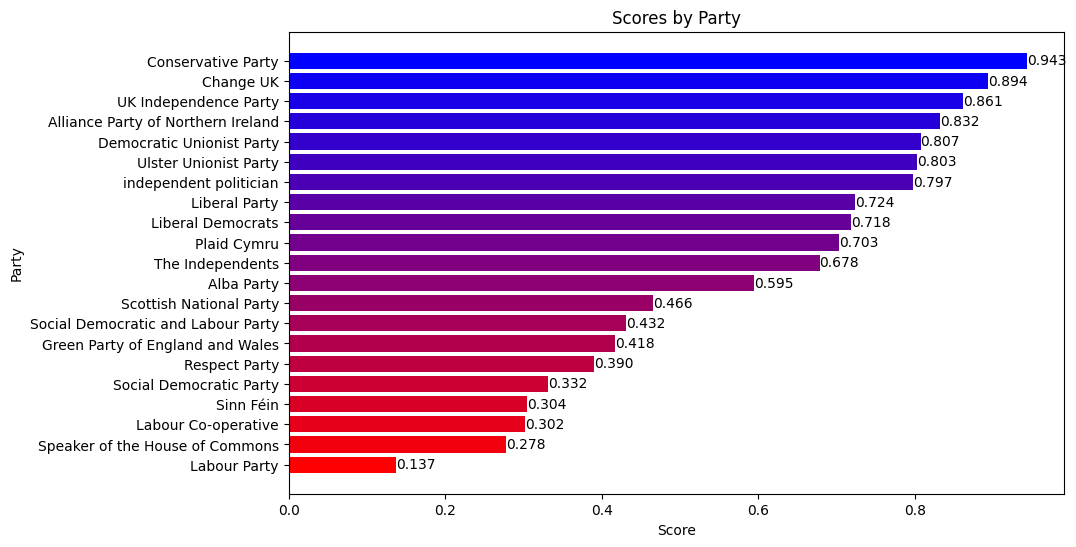

In [71]:
cmap = LinearSegmentedColormap.from_list('red_blue', [(1, 0, 0), (0, 0, 1)], N=len(grouped_parties))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(grouped_parties['partyLabel'], grouped_parties['pred'], color=cmap(np.linspace(0, 1, len(grouped_parties))))

for bar, pred in zip(bars, grouped_parties['pred']):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{pred:.3f}', va='center', ha='left')

ax.set_xlabel('Score')
ax.set_ylabel('Party')
ax.set_title('Scores by Party')

plt.show()

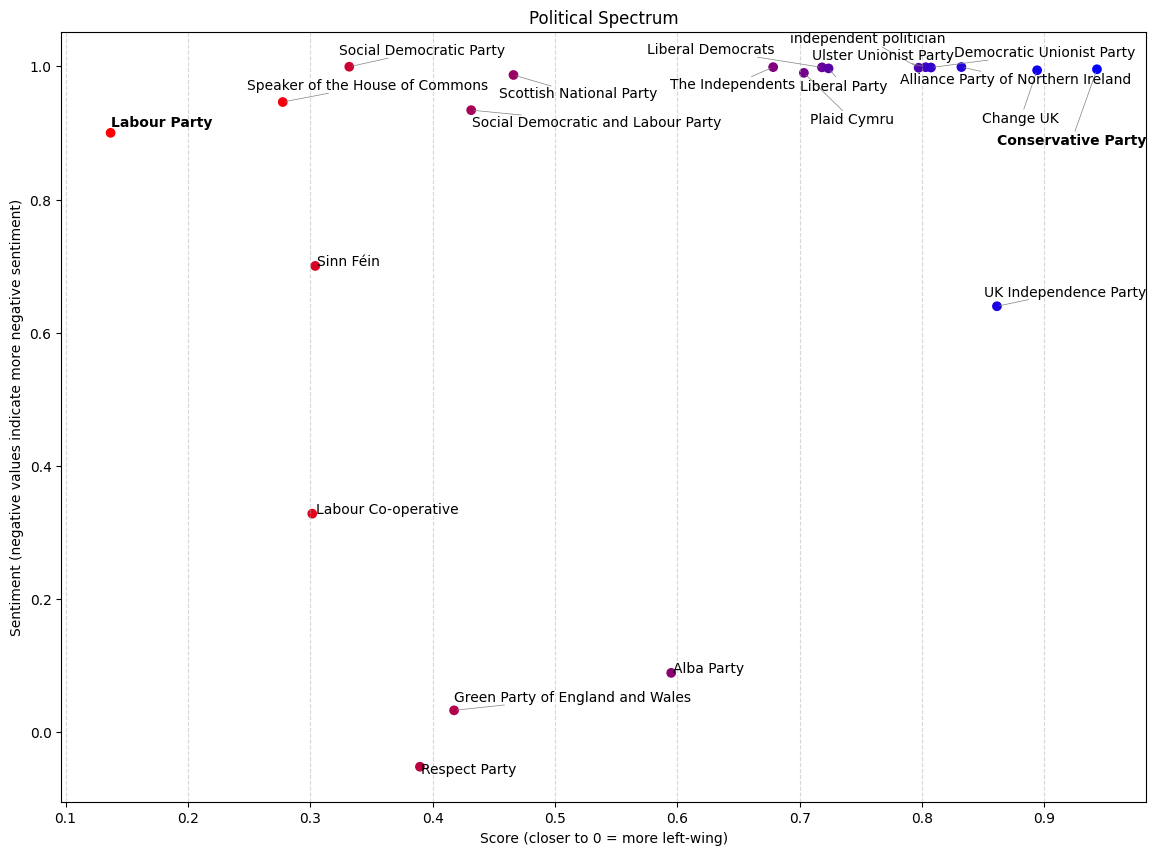

In [72]:
cmap = LinearSegmentedColormap.from_list('red_blue', [(1, 0, 0), (0, 0, 1)], N=len(grouped_parties))

plt.figure(figsize=(14, 10))
scatter = plt.scatter(grouped_parties['pred'], grouped_parties['sentiment'], c=range(len(grouped_parties)), cmap=cmap)

texts = []
for x, y, txt in zip(grouped_parties['pred'], grouped_parties['sentiment'], grouped_parties['partyLabel']):
    if txt == 'Conservative Party' or txt == 'Labour Party':
        texts.append(plt.text(x, y, txt, weight='bold'))
    else:
        texts.append(plt.text(x, y, txt))

adjust_text(texts, expand=(1, 2), arrowprops=dict(arrowstyle='-', lw=0.5, color='grey'))

plt.xlabel('Score (closer to 0 = more left-wing)')
plt.ylabel('Sentiment (negative values indicate more negative sentiment)')
plt.title('Political Spectrum')

plt.grid(axis='x', alpha=0.5, linestyle='--')

plt.show()